In [1]:
import numpy as np
import random
import copy
import pandas as pd
import gc
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [963]:
gc.collect()

4

In [1025]:
%who

bestInd	 calRoulette	 chooseOneNumByRoulette	 chooseTwoNumByRoulette	 copy	 di	 dictkey	 gc	 i	 
individual	 individualLotSplitingCode	 individualPreferenceCode	 inneritem	 item	 lotInd	 lotNum	 lotOpeartionNumList	 lotSizes	 
machine	 machineMatrix	 machineNum	 makespans	 matplotlib	 np	 operationNumOfMachine	 outeritem	 pd	 
plt	 population	 preferenceCode	 preparingTimeMatrix	 problemInd	 random	 singleLotSplitingVec	 solu	 solution	 
sublotNum	 sublotSizes	 temp1	 temp2	 test	 testIndividual	 timeMatrix	 timeMatrixWithLotSize	 


In [961]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


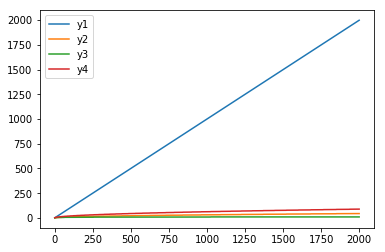

In [14]:
# 测试怎么限制sublotSize比较好

x=range(1,2000,1)
y1=x
y2=[int(item) for item in np.sqrt(x)]
y3=[int(item) for item in np.log2(x)]
y4=[int(item) for item in np.sqrt(x)*2]  # 曲线看起来最好的是这个

label=['y1','y2','y3','y4']
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.legend(label)

In [18]:
y4[30]

11

In [2]:
# 一个lot的lotSplitingVector

class singleLotSplitingVec:
    
    def __init__(self, lotSize):
        """
        self.lotSize  本批共有多少个工件
        """
        self.lotSize = lotSize
        
    def initializeLotSplitingVec(self):
        """
        随机初始化一个批的分批方案向量
        self.sublotNum  子批数
        self.sublotSizes  list，每个子批包含多少个工件
        """
        # 限制子批数量，也可以不限制子批数量
        # self.sublotNum = random.randint(1, int(np.log2(self.lotSize)))  
#         self.sublotNum = random.randint(1, 2 * int(np.sqrt(self.lotSize)))  
        # self.lotNum = random.randint(1, self.lotSize)  # 
        if(self.lotSize > 30):
            self.sublotNum = random.randint(1, 2 * int(np.sqrt(30)))  # 超100的就不分那么多sublot了
        else:
            self.sublotNum = random.randint(1, 2 * int(np.sqrt(self.lotSize)))  
            
        self.sublotSizes = [1] * self.sublotNum
        cnt = self.sublotNum
        while(cnt < self.lotSize):
            self.sublotSizes[random.randint(1, self.sublotNum) - 1] += 1
            cnt += 1
    
    def mutateTwoSublot(self):
        """
        lot内变异两个sublot的size，即变异一个分批方案向量，随机选择两个子批，重新随机生成这两个子批的批量，使之与变异前不同
        """
        if(self.sublotNum > 1):   # 当子批数大于1的时候，才可以发生变异      
            pos1 = random.randint(1, self.sublotNum) - 1
            pos2 = random.randint(1, self.sublotNum) - 1
            while(pos1 == pos2):
                pos2 = random.randint(1, self.sublotNum) - 1
            # print(pos1+1, pos2+1)
   
            sumSize = self.sublotSizes[pos1] + self.sublotSizes[pos2]
            if(sumSize > 3):  # 如果选中的是两个1的sublot，或者是一个1一个2的sublot，则不进行变异，如果不是这种情况，才有以下的变异
                newSize1 = random.randint(1, sumSize - 1)
                while(newSize1 == self.sublotSizes[pos1] or newSize1 == self.sublotSizes[pos2]):
                    newSize1 = random.randint(1, sumSize - 1)
                self.sublotSizes[pos1] = newSize1
                self.sublotSizes[pos2] = sumSize - newSize1
                # print(sumSize, newSize1)


In [18]:
# singleLotSplitingVec类测试代码

test = singleLotSplitingVec(10)
print(test.lotSize)

test.initializeLotSplitingVec()
print(test.sublotNum)
print(test.sublotSizes)

test.mutateTwoSublot()
print(test.sublotSizes)

10
3
[2, 5, 3]
[4, 5, 1]


In [3]:
# 一个个体所有lot的lotSplitingCode
class individualLotSplitingCode:
    
    def __init__(self, lotNum, lotSizes):
        """
        self.lotNum  一个个体有多少个lot
        self.lotSizes  list，每个lot有多少个工件
        """
        self.lotNum = lotNum
        self.lotSizes = lotSizes
        
    def initilizeLotSplitingCode(self):
        """
        根据lotSizes初始化lotNum个lotSplitingVec，随机初始化
        self.lotSplitingCode  list，一个个体所有lot的lotSplitingVec组成的list
        """
        self.lotSplitingCode = []
        for num in self.lotSizes:
            self.lotSplitingCode.append(singleLotSplitingVec(num))
        for item in self.lotSplitingCode:
            item.initializeLotSplitingVec()
            
    def mutateWithinLotWithTwoSublots(self, p):
        """
        按照概率p来随机抽取lot进行lot内两个sublotSize的变异
        p  单个Vec变异的概率
        """
        for item in self.lotSplitingCode:
            if(random.random() < p):
                item.mutateTwoSublot()
                
    def mutateWithinLotWithNewVec(self, p):
        """
        按照概率p来随机抽取lot进行lot内分批方案vec重新随机初始化
        p  单个Vec变异的概率
        """
        for item in self.lotSplitingCode:
            if(random.random() < p):
                item.initializeLotSplitingVec()
                  

In [21]:
# individualLotSplitingCode类测试代码

print('创建')

test = individualLotSplitingCode(5,[10,20,30,25,15])
print(test.lotNum)
print(test.lotSizes)

print('初始化')

test.initilizeLotSplitingCode()
for item in test.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)

print('lot内两sublot变异后')

test.mutateWithinLotWithTwoSublots(0.5)
for item in test.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)

print('lot内整个分批方案变异后')

test.mutateWithinLotWithNewVec(0.5)
for item in test.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)

创建
5
[10, 20, 30, 25, 15]
初始化
10 6 [1, 3, 1, 2, 1, 2]
20 6 [2, 3, 4, 3, 5, 3]
30 1 [30]
25 7 [5, 5, 2, 3, 5, 3, 2]
15 2 [8, 7]
lot内两sublot变异后
10 6 [1, 3, 1, 2, 1, 2]
20 6 [2, 3, 4, 3, 5, 3]
30 1 [30]
25 7 [5, 5, 2, 3, 5, 3, 2]
15 2 [2, 13]
lot内整个分批方案变异后
10 6 [1, 3, 1, 2, 1, 2]
20 3 [7, 6, 7]
30 2 [12, 18]
25 8 [3, 4, 3, 3, 4, 3, 1, 4]
15 5 [2, 4, 5, 2, 2]


In [4]:
# 一个个体所有机器的preferenceCode
class individualPreferenceCode:
    """
    注意：lot号从0开始数
    """
    
    def __init__(self, machineNum, lotNum):
        """
        self.machineNum  机器数量
        self.lotNum  一个个体有多少个lot
        """
        self.machineNum = machineNum
        self.lotNum = lotNum
        
    def initilizePreferenceCode(self):
        """
        随机初始化self.machineNum台机器的preferenceCode
        self.preferenceCode list，一个个体所有机器的preferenceVec组成的list
        """
        self.preferenceCode = []        
        for i in range(self.machineNum):
            preferenceVec = [item for item in range(self.lotNum)]
            random.shuffle(preferenceVec)
            self.preferenceCode.append(preferenceVec)
            
    def mutateWithinVecWithSwap(self, p):
        """
        按照概率p选取机器的preferenceVec进行Vec内两点swap
        p  单个Vec变异的概率
        """
        for item in self.preferenceCode:
            if(random.random() < p):                
                pos1 = random.randint(1, self.lotNum) - 1
                pos2 = random.randint(1, self.lotNum) - 1
                while(pos1 == pos2):
                    pos2 = random.randint(1, self.lotNum) - 1
                item[pos1], item[pos2] = item[pos2], item[pos1]
                
    def mutateBetweenVecsWithSwap(self):
        """
        随机抽取两个preferenceVec，swap
        """
        pos1 = random.randint(1, self.machineNum) - 1
        pos2 = random.randint(1, self.machineNum) - 1
        while(pos1 == pos2):
            pos2 = random.randint(1, self.machineNum) - 1
        self.preferenceCode[pos1], self.preferenceCode[pos2] = self.preferenceCode[pos2], self.preferenceCode[pos1]

In [23]:
# individualPreferenceCode类测试代码

print('创建并初始化')

test=individualPreferenceCode(5,10)
print(test.machineNum, test.lotNum)
test.initilizePreferenceCode()
for item in test.preferenceCode:
    print(item)

print('Vec内两点swap变异后')

test.mutateWithinVecWithSwap(0.5)
for item in test.preferenceCode:
    print(item)
    
print('随机两个Vec进行swap变异后')

test.mutateBetweenVecsWithSwap()
for item in test.preferenceCode:
    print(item)

创建并初始化
5 10
[1, 6, 8, 5, 2, 3, 7, 4, 9, 0]
[9, 7, 8, 5, 4, 6, 0, 3, 2, 1]
[6, 2, 8, 7, 1, 9, 5, 0, 3, 4]
[1, 4, 5, 3, 8, 2, 7, 0, 9, 6]
[0, 1, 7, 5, 6, 8, 4, 2, 3, 9]
Vec内两点swap变异后
[1, 7, 8, 5, 2, 3, 6, 4, 9, 0]
[9, 7, 8, 5, 4, 6, 0, 3, 2, 1]
[6, 2, 3, 7, 1, 9, 5, 0, 8, 4]
[1, 4, 5, 3, 8, 2, 6, 0, 9, 7]
[0, 1, 7, 5, 6, 9, 4, 2, 3, 8]
随机两个Vec进行swap变异后
[0, 1, 7, 5, 6, 9, 4, 2, 3, 8]
[9, 7, 8, 5, 4, 6, 0, 3, 2, 1]
[6, 2, 3, 7, 1, 9, 5, 0, 8, 4]
[1, 4, 5, 3, 8, 2, 6, 0, 9, 7]
[1, 7, 8, 5, 2, 3, 6, 4, 9, 0]


In [5]:
# 一个完整的个体
class individual:
    
    def __init__(self, lotNum, lotSizes, machineNum):
        """
        self.lotNum  有多少个lot
        self.lotSizes  list，每个lot有多少个工件
        self.machineNum  有多少个机器
        """
        self.lotNum = lotNum
        self.lotSizes = lotSizes
        self.machineNum = machineNum
        
    def initializeIndividual(self):
        """
        随机初始化一个个体的两段编码
        self.segment1  S1,分批段
        self.segment2  S2,偏好段
        self.makespan  该个体的完工时间，初始值为一个很大的数
        """
        self.segment1 = individualLotSplitingCode(self.lotNum, self.lotSizes)
        self.segment1.initilizeLotSplitingCode()
        self.segment2 = individualPreferenceCode(self.machineNum, self.lotNum)
        self.segment2.initilizePreferenceCode()
        self.makespan = 100000
        
    def mutateSegment1WithTwoSublots(self, p):
        """
        按照概率p随机选择lotSplitingVec，对其随机两个sublot的size扰动
        p  单个Vec变异的概率
        """
        self.segment1.mutateWithinLotWithTwoSublots(p)
        
    def mutateSegment1WithNewVec(self, p):
        """
        按照概率p随机选择lotSplitingVec，对整个向量重新初始化
        p  单个Vec变异的概率
        """
        self.segment1.mutateWithinLotWithNewVec(p)
        
    def mutateSegment2WithinVecWithSwap(self, p):
        """
        按照概率p随机选择preferenceVec，对Vec内两个位置swap
        p  单个Vec变异的概率
        """
        self.segment2.mutateWithinVecWithSwap(p)
        
    def mutateSgment2BetweenTwoVecs(self):
        """
        随机选两个preferenceVec进行swap
        """
        self.segment2.mutateBetweenVecsWithSwap()
        
    def crossoverBetweenSegment1s(indi1, indi2, p):
        """
        按概率p选位，交叉两个individual的segment1的位（以一个lot为一位）
        """
        for i in range(indi1.lotNum):
            if(random.random() < p):
                indi1.segment1.lotSplitingCode[i], indi2.segment1.lotSplitingCode[i] = \
                indi2.segment1.lotSplitingCode[i], indi1.segment1.lotSplitingCode[i]
                
    def crossoverBetweenSegment2s(indi1, indi2, p):
        """
        按概率p选位，交叉两个individual的segment2的位（以一台机器为一位）
        """
        for i in range(indi1.machineNum):
            if(random.random() < p):
                indi1.segment2.preferenceCode[i], indi2.segment2.preferenceCode[i] = \
                indi2.segment2.preferenceCode[i], indi1.segment2.preferenceCode[i]
        
    def decode(self):
        """
        计算并返回完工时间
        """
        solu = solution(self)
        solu.run()
        self.makespan = solu.getMakespan()
#         return self.makespan

        

In [448]:
# individual类测试代码2

test1=individual(4,[8,8,8,8],6)
test1.initializeIndividual()
test2=individual(4,[8,8,8,8],6)
test2.initializeIndividual()

print('交叉前')
for item in test1.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
print(' ')
for item in test2.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)

test1.crossoverBetweenSegment1s(test2, 0.5)

print('交叉后')
for item in test1.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
print(' ')
for item in test2.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)

    
print('交叉前')
for item in test1.segment2.preferenceCode:
    print(item)
print(' ')
for item in test2.segment2.preferenceCode:
    print(item)
    
test1.crossoverBetweenSegment2s(test2, 0.5)

print('交叉后')
for item in test1.segment2.preferenceCode:
    print(item)
print(' ')
for item in test2.segment2.preferenceCode:
    print(item)



交叉前
8 3 [2, 3, 3]
8 1 [8]
8 1 [8]
8 1 [8]
 
8 1 [8]
8 4 [2, 3, 1, 2]
8 4 [1, 3, 2, 2]
8 1 [8]
交叉后
8 3 [2, 3, 3]
8 1 [8]
8 1 [8]
8 1 [8]
 
8 1 [8]
8 4 [2, 3, 1, 2]
8 4 [1, 3, 2, 2]
8 1 [8]
交叉前
[0, 1, 2, 3]
[2, 1, 3, 0]
[2, 0, 1, 3]
[1, 3, 0, 2]
[2, 1, 0, 3]
[1, 2, 0, 3]
 
[2, 0, 3, 1]
[0, 2, 1, 3]
[0, 2, 3, 1]
[2, 0, 3, 1]
[0, 1, 3, 2]
[3, 1, 2, 0]
交叉后
[0, 1, 2, 3]
[2, 1, 3, 0]
[0, 2, 3, 1]
[2, 0, 3, 1]
[2, 1, 0, 3]
[3, 1, 2, 0]
 
[2, 0, 3, 1]
[0, 2, 1, 3]
[2, 0, 1, 3]
[1, 3, 0, 2]
[0, 1, 3, 2]
[1, 2, 0, 3]


In [441]:
# individual类测试代码1

print('创建')

test=individual(4,[8,8,8,8],6)
print(test.lotNum,test.lotSizes,test.machineNum)

print('初始化后')

test.initializeIndividual()
for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in test.segment2.preferenceCode:
    print(item)
test.decode()
print('完工时间: ', test.makespan)
    
print('lot内两sublotSize变异后')

test.mutateSegment1WithTwoSublots(0.5)
for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
test.decode()
print('完工时间: ', test.makespan)
    
print('lotSplitingVec重新初始化变异后')

test.mutateSegment1WithNewVec(0.5)
for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
test.decode()
print('完工时间: ', test.makespan)
    
print('preferenceVec内swap变异后')

test.mutateSegment2WithinVecWithSwap(0.5)
for item in test.segment2.preferenceCode:
    print(item)
test.decode()
print('完工时间: ', test.makespan)
    
print('两个preferenceVec进行swap变异后')    
    
test.mutateSgment2BetweenTwoVecs()
for item in test.segment2.preferenceCode:
    print(item)
test.decode()
print('完工时间: ', test.makespan)




创建
4 [8, 8, 8, 8] 6
初始化后
8 2 [4, 4]
8 4 [3, 1, 2, 2]
8 2 [4, 4]
8 3 [2, 2, 4]
[2, 3, 0, 1]
[2, 3, 1, 0]
[2, 3, 1, 0]
[2, 3, 0, 1]
[3, 1, 2, 0]
[3, 2, 1, 0]
完工时间:  114
lot内两sublotSize变异后
8 2 [5, 3]
8 4 [3, 1, 2, 2]
8 2 [4, 4]
8 3 [2, 2, 4]
完工时间:  114
lotSplitingVec重新初始化变异后
8 2 [5, 3]
8 4 [3, 1, 2, 2]
8 2 [4, 4]
8 3 [2, 2, 4]
完工时间:  114
preferenceVec内swap变异后
[3, 2, 0, 1]
[2, 3, 1, 0]
[3, 2, 1, 0]
[2, 1, 0, 3]
[0, 1, 2, 3]
[3, 2, 1, 0]
完工时间:  137
两个preferenceVec进行swap变异后
[3, 2, 0, 1]
[2, 3, 1, 0]
[3, 2, 1, 0]
[3, 2, 1, 0]
[0, 1, 2, 3]
[2, 1, 0, 3]
完工时间:  124
8 2 [2, 6]
8 4 [3, 1, 2, 2]
8 1 [8]
8 3 [3, 3, 2]
8 2 [5, 3]
8 2 [3, 5]
8 2 [4, 4]
8 3 [2, 2, 4]


In [374]:
# individual类decode函数测试代码

print('创建')

test=individual(4,[8,8,8,8],6)
print(test.lotNum,test.lotSizes,test.machineNum)

print('初始化')

test.initializeIndividual()
for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in test.segment2.preferenceCode:
    print(item)

test.decode()
print('完工时间: ', test.makespan)


创建
4 [8, 8, 8, 8] 6
初始化
8 2 [6, 2]
8 4 [2, 2, 2, 2]
8 1 [8]
8 1 [8]
[2, 0, 1, 3]
[2, 0, 3, 1]
[1, 3, 2, 0]
[2, 1, 3, 0]
[1, 2, 3, 0]
[2, 0, 3, 1]
完工时间:  193


In [450]:
# individual类测试代码3

print('创建')

test=individual(4,[8,8,8,8],6)
print(test.lotNum,test.lotSizes,test.machineNum)

print('初始化后')
test.initializeIndividual()
test.decode()
print('完工时间: ', test.makespan)
    
print('lot内两sublotSize变异后')
test.mutateSegment1WithTwoSublots(0.5)
test.decode()
print('完工时间: ', test.makespan)
    
print('lotSplitingVec重新初始化变异后')
test.mutateSegment1WithNewVec(0.5)
test.decode()
print('完工时间: ', test.makespan)
    
print('preferenceVec内swap变异后')
test.mutateSegment2WithinVecWithSwap(0.5)
test.decode()
print('完工时间: ', test.makespan)
    
print('两个preferenceVec进行swap变异后')       
test.mutateSgment2BetweenTwoVecs()
test.decode()
print('完工时间: ', test.makespan)


test1=individual(4,[8,8,8,8],6)
test1.initializeIndividual()
test2=individual(4,[8,8,8,8],6)
test2.initializeIndividual()
test1.decode()
test2.decode()
print('完工时间: ', test1.makespan, test1.makespan)

print('两个个体的Segment1进行交叉后') 
test1.crossoverBetweenSegment1s(test2, 0.5)
test1.decode()
test2.decode()
print('完工时间: ', test1.makespan, test1.makespan)


print('两个个体的Segment2进行交叉后')    
test1.crossoverBetweenSegment2s(test2, 0.5)
test1.decode()
test2.decode()
print('完工时间: ', test1.makespan, test1.makespan)

创建
4 [8, 8, 8, 8] 6
初始化后
完工时间:  140
lot内两sublotSize变异后
完工时间:  139
lotSplitingVec重新初始化变异后
完工时间:  130
preferenceVec内swap变异后
完工时间:  144
两个preferenceVec进行swap变异后
完工时间:  193
完工时间:  232 232
两个个体的Segment1进行交叉后
完工时间:  234 234
两个个体的Segment2进行交叉后
完工时间:  195 195


In [6]:
# 一些外部函数

def calRoulette(makespanList):
    """
    由完工时间列表计算轮盘
    makespanList  输入一个完工时间的list
    roulette      输出一个轮盘概率list
    """
    makespanMax = max(makespanList)
    for i in range(len(makespanList)):
        makespanList[i] = makespanMax - makespanList[i] + 1
    makespanSum = sum(makespanList)    
    for i in range(len(makespanList)):
        makespanList[i] /=  makespanSum
    roulette = []
    temp = 0
    for i in range(len(makespanList)):
        temp += makespanList[i]
        roulette.append(temp)
    return roulette

def chooseOneNumByRoulette(roulette):
    """
    用轮盘来随机选取一个数
    roulette      输入一个轮盘概率list
    i             输出一个[0,len(roulette)-1]的随机数
    """    
    randNum = random.random()
    for i in range(len(roulette)):
        if(randNum < roulette[i]):
            break
    return i

def chooseTwoNumByRoulette(roulette): 
    """
    用轮盘赌来随机选取两个不同的数
    roulette      输入一个轮盘概率list
    pos1, pos2    输出两个不同的[0,len(roulette)-1]的随机数
    """
    pos1 = chooseOneNumByRoulette(roulette)
    pos2 = chooseOneNumByRoulette(roulette)
    while(pos1 == pos2):
        pos2 = chooseOneNumByRoulette(roulette)
    return pos1, pos2

In [19]:
# 全局变量

problemInd = 3

""" 
problemInd               问题编号，需要手动指定
timeMatrix               每种lot的每个工序由不同的机器加工需要多少时间
preparingTimeMatrix      工序准备时间
lotNum                   有多少个lot
machineMatrix            每种lot的每个工序都可以由哪几台机器加工
lotOpeartionNumList      list，每种lot各有多少个工序
machineNum               有多少台机器
operationNumOfMachine    每台机器可以加工多少个不同的工序
"""


# P1：4X6问题，来自王海燕
if(problemInd == 1):
    timeMatrix=[ [ {0: 2, 1: 3, 2: 4}, {1: 3, 3: 2, 4: 4}, {0: 1, 1: 4, 2: 5} ],\
                 [ {0: 3, 2: 5, 4: 2}, {0: 4, 1: 3, 4: 6}, {2: 4, 4: 7, 5: 11} ],\
                 [ {0: 5, 1: 6      }, {1: 4, 3: 3, 4: 5}, {2: 13, 4: 9, 5: 12} ],\
                 [ {0: 9, 2: 7, 3: 9}, {1: 6, 3: 4, 5: 5}, {0: 1, 2: 3, 5: 3} ] ]

    preparingTimeMatrix=[ [ {0: 2, 1: 3, 2: 4}, {1: 3, 3: 2, 4: 4}, {0: 1, 1: 4, 2: 5} ],\
                          [ {0: 3, 2: 5, 4: 2}, {0: 4, 1: 3, 4: 6}, {2: 4, 4: 7, 5: 11} ],\
                          [ {0: 5, 1: 6      }, {1: 4, 3: 3, 4: 5}, {2: 13, 4: 9, 5: 12} ],\
                          [ {0: 9, 2: 7, 3: 9}, {1: 6, 3: 4, 5: 5}, {0: 1, 2: 3, 5: 3} ] ]

    lotSizes = [8,8,8,8]

# P2：4X6问题，来自王海燕
elif(problemInd == 2):
    timeMatrix=[ [ {0: 2, 1: 3, 2: 4}, {1: 3, 3: 2, 4: 4}, {0: 1, 1: 2, 2: 5} ],\
                 [ {0: 3, 2: 5, 4: 2}, {0: 4, 1: 3, 4: 6}, {2: 4, 4: 7, 5: 11} ],\
                 [ {0: 5, 1: 6      }, {1: 4, 3: 3, 4: 5}, {2: 13, 4: 9, 5: 12} ],\
                 [ {0: 9, 2: 7, 3: 9}, {1: 6, 3: 4, 5: 5}, {0: 1, 2: 3, 5: 3} ] ]

    preparingTimeMatrix=[ [ {0: 2, 1: 3, 2: 4}, {1: 3, 3: 2, 4: 4}, {0: 1, 1: 2, 2: 5} ],\
                          [ {0: 3, 2: 5, 4: 2}, {0: 4, 1: 3, 4: 6}, {2: 4, 4: 7, 5: 11} ],\
                          [ {0: 5, 1: 6      }, {1: 4, 3: 3, 4: 5}, {2: 13, 4: 9, 5: 12} ],\
                          [ {0: 9, 2: 7, 3: 9}, {1: 6, 3: 4, 5: 5}, {0: 1, 2: 3, 5: 3} ] ]

    lotSizes = [20,20,20,20]

# P3：6X6问题，来自王海燕
elif(problemInd == 3):
    timeMatrix=[ [ {0: 2}, {2: 3, 3: 2}, {1: 2, 3: 2, 4: 3, 5: 2}, {1: 5, 3: 6}, {2: 2, 5: 2}, {1: 1, 4: 1} ],\
                 [ {1: 2, 3: 1}, {2: 4}, {0: 8, 4: 7, 5: 7}, {1: 4, 2: 5, 3: 5}, {2: 1, 5: 1}, {1: 4, 4: 5} ],\
                 [ {0: 4, 2: 5}, {1: 5, 3: 5}, {2: 1, 4: 1}, {1: 6, 4: 7}, {1: 2, 2: 2, 5: 3} ],\
                 [ {0: 4, 3: 4}, {2: 2}, {1: 4, 3: 3, 5: 3}, {2: 6, 4: 5}, {0: 6}, {1: 3, 3: 2, 4: 2} ],\
                 [ {0: 2, 3: 3}, {1: 5, 4: 4}, {2: 1, 3: 1}, {2: 3, 5: 2}, {1: 3, 2: 2}, {4: 2} ],\
                 [ {0: 2, 2: 3, 4: 2}, {1: 4, 4: 3}, {3: 6, 5: 6}, {1: 2, 3: 2}, {2: 1}, {0: 2, 3: 3, 4: 2} ] ]

    preparingTimeMatrix =[ [ {0: 1}, {2: 2, 3: 1}, {1: 1, 3: 2, 4: 2, 5: 1}, {1: 3, 3: 2}, {2: 1, 5: 1}, {1: 1, 4: 1} ],\
                           [ {1: 1, 3: 1}, {2: 2}, {0: 2, 4: 2, 5: 3}, {1: 2, 2: 1, 3: 2}, {2: 1, 5: 1}, {1: 2, 4: 1} ],\
                           [ {0: 2, 2: 2}, {1: 3, 3: 2}, {2: 1, 4: 1}, {1: 3, 4: 2}, {1: 2, 2: 1, 5: 1} ],\
                           [ {0: 2, 3: 1}, {2: 1}, {1: 1, 3: 1, 5: 1}, {2: 2, 4: 2}, {0: 1}, {1: 1, 3: 2, 4: 1} ],\
                           [ {0: 1, 3: 1}, {1: 1, 4: 1}, {2: 1, 3: 1}, {2: 1, 5: 1}, {1: 1, 2: 2}, {4: 2} ],\
                           [ {0: 1, 2: 1, 4: 2}, {1: 1, 4: 2}, {3: 2, 5: 1}, {1: 1, 3: 1}, {2: 2}, {0: 2, 3: 1, 4: 2} ] ]
    lotSizes = [10,10,10,10,10,10]

# P4：6X6问题，来自王海燕
elif(problemInd == 4):
    timeMatrix=[ [ {0: 2}, {2: 3, 3: 2}, {1: 2, 3: 2, 4: 3, 5: 2}, {1: 5, 3: 6}, {2: 2, 5: 2}, {1: 1, 4: 1} ],\
                 [ {1: 2, 3: 1}, {2: 4}, {0: 8, 4: 7, 5: 7}, {1: 4, 2: 5, 3: 5}, {2: 1, 5: 1}, {1: 4, 4: 5} ],\
                 [ {0: 4, 2: 5}, {1: 5, 3: 5}, {2: 1, 4: 1}, {1: 6, 4: 7}, {1: 2, 2: 2, 5: 3} ],\
                 [ {0: 4, 3: 4}, {2: 2}, {1: 4, 3: 3, 5: 3}, {2: 6, 4: 5}, {0: 6}, {1: 3, 3: 2, 4: 2} ],\
                 [ {0: 2, 3: 3}, {1: 4, 4: 4}, {2: 1, 3: 1}, {2: 3, 5: 2}, {1: 3, 2: 2}, {4: 2} ],\
                 [ {0: 2, 2: 3, 4: 2}, {1: 4, 4: 3}, {3: 6, 5: 6}, {1: 2, 3: 2}, {2: 1}, {0: 2, 3: 3, 4: 2} ] ]

    preparingTimeMatrix =[ [ {0: 1}, {2: 2, 3: 1}, {1: 1, 3: 2, 4: 2, 5: 1}, {1: 3, 3: 2}, {2: 1, 5: 1}, {1: 1, 4: 1} ],\
                           [ {1: 1, 3: 1}, {2: 2}, {0: 2, 4: 2, 5: 3}, {1: 2, 2: 1, 3: 2}, {2: 1, 5: 1}, {1: 2, 4: 1} ],\
                           [ {0: 2, 2: 2}, {1: 3, 3: 2}, {2: 1, 4: 1}, {1: 3, 4: 2}, {1: 2, 2: 1, 5: 1} ],\
                           [ {0: 2, 3: 1}, {2: 1}, {1: 1, 3: 1, 5: 1}, {2: 2, 4: 2}, {0: 1}, {1: 1, 3: 2, 4: 1} ],\
                           [ {0: 1, 3: 1}, {1: 1, 4: 1}, {2: 1, 3: 1}, {2: 1, 5: 1}, {1: 1, 2: 2}, {4: 2} ],\
                           [ {0: 1, 2: 1, 4: 2}, {1: 1, 4: 2}, {3: 2, 5: 1}, {1: 1, 3: 1}, {2: 2}, {0: 2, 3: 1, 4: 2} ] ]
    lotSizes = [20,20,20,20,20,20]
    
# P5：5X12问题，来自ZHAO
elif(problemInd == 5):
    timeMatrix=[ [ {5: 5, 6: 7, 7: 8}, {4: 10}, {3: 2}, {4: 5}, {10: 12, 11: 14} ],\
                 [ {5: 5, 6: 9, 7: 6}, {8: 3, 9: 4}, {1: 4, 2: 4}, {1: 15, 2: 7}, {1: 5, 2: 5}, {10: 10, 11: 8} ],\
                 [ {5: 5, 6: 7, 7: 8}, {5: 6, 6: 6, 7: 10}, {8: 4, 9: 5}, {1: 15, 2: 14}, {1: 5, 2: 3}, {10: 10, 11: 11} ],\
                 [ {4: 6}, {0: 4}, {8: 3, 9: 5}, {4: 5}, {10: 6, 11: 9} ],\
                 [ {5: 5, 6: 6, 7: 6}, {5: 5, 6: 5, 7: 6}, {8: 5, 9: 5}, {3: 6}, {1: 9, 2: 10}, {1: 5, 2: 4}, {10: 9, 11: 10} ] ]

    preparingTimeMatrix =[ [ {5: 5, 6: 5, 7: 5}, {4: 2}, {3: 4}, {4: 2}, {10: 0, 11: 0} ],\
                           [ {5: 5, 6: 4, 7: 7}, {8: 0, 9: 0}, {1: 8, 2: 3}, {1: 4, 2: 7}, {1: 3, 2: 3}, {10: 0, 11: 0} ],\
                           [ {5: 4, 6: 6, 7: 6}, {5: 6, 6: 8, 7: 6}, {8: 0, 9: 0}, {1: 5, 2: 3}, {1: 3, 2: 1}, {10: 0, 11: 0} ],\
                           [ {4: 2}, {0: 2}, {8: 0, 9: 0}, {4: 3}, {10: 0, 11: 0} ],\
                           [ {5: 4, 6: 4, 7: 5}, {5: 6, 6: 6, 7: 6}, {8: 0, 9: 0}, {3: 4}, {1: 2, 2: 4}, {1: 2, 2: 2}, {10: 0, 11: 0} ] ]
    lotSizes = [600,500,1800,2000,500]




# 由上面两个矩阵计算得到一些全局变量
lotNum = len(timeMatrix)

machineMatrix = [ [ [item for item in operation.keys()] for operation in lot ] for lot in timeMatrix ]

lotOpeartionNumList = [len(item) for item in timeMatrix]


            
temp1 = []
temp2 = [] 
operationNumOfMachine = []
for i, item in enumerate(timeMatrix):
    temp1.extend(item * lotSizes[i])
for i, item in enumerate(temp1):
    temp1[i] = list(item.keys())
for item in temp1:
    temp2.extend(item)
    
machineNum = len(set(temp2))    

for i in range(machineNum):
    operationNumOfMachine.append(temp2.count(i))
    

# 打印上述所有参数
print('timeMatrix: ')
for item in timeMatrix:
    print(item)
print('preparingTimeMatrix: ')
for item in preparingTimeMatrix:
    print(item)
print('lotSizes: ', lotSizes)
print('lotNum: ', lotNum)
print('machineMatrix: ')
for item in machineMatrix:
    print(item)
print('lotOpeartionNumList: ', lotOpeartionNumList)
print('machineNum: ', machineNum)
print('operationNumOfMachine: ', operationNumOfMachine)



timeMatrix: 
[{0: 2}, {2: 3, 3: 2}, {1: 2, 3: 2, 4: 3, 5: 2}, {1: 5, 3: 6}, {2: 2, 5: 2}, {1: 1, 4: 1}]
[{1: 2, 3: 1}, {2: 4}, {0: 8, 4: 7, 5: 7}, {1: 4, 2: 5, 3: 5}, {2: 1, 5: 1}, {1: 4, 4: 5}]
[{0: 4, 2: 5}, {1: 5, 3: 5}, {2: 1, 4: 1}, {1: 6, 4: 7}, {1: 2, 2: 2, 5: 3}]
[{0: 4, 3: 4}, {2: 2}, {1: 4, 3: 3, 5: 3}, {2: 6, 4: 5}, {0: 6}, {1: 3, 3: 2, 4: 2}]
[{0: 2, 3: 3}, {1: 5, 4: 4}, {2: 1, 3: 1}, {2: 3, 5: 2}, {1: 3, 2: 2}, {4: 2}]
[{0: 2, 2: 3, 4: 2}, {1: 4, 4: 3}, {3: 6, 5: 6}, {1: 2, 3: 2}, {2: 1}, {0: 2, 3: 3, 4: 2}]
preparingTimeMatrix: 
[{0: 1}, {2: 2, 3: 1}, {1: 1, 3: 2, 4: 2, 5: 1}, {1: 3, 3: 2}, {2: 1, 5: 1}, {1: 1, 4: 1}]
[{1: 1, 3: 1}, {2: 2}, {0: 2, 4: 2, 5: 3}, {1: 2, 2: 1, 3: 2}, {2: 1, 5: 1}, {1: 2, 4: 1}]
[{0: 2, 2: 2}, {1: 3, 3: 2}, {2: 1, 4: 1}, {1: 3, 4: 2}, {1: 2, 2: 1, 5: 1}]
[{0: 2, 3: 1}, {2: 1}, {1: 1, 3: 1, 5: 1}, {2: 2, 4: 2}, {0: 1}, {1: 1, 3: 2, 4: 1}]
[{0: 1, 3: 1}, {1: 1, 4: 1}, {2: 1, 3: 1}, {2: 1, 5: 1}, {1: 1, 2: 2}, {4: 2}]
[{0: 1, 2: 1, 4: 2}, {1: 1, 

In [8]:
# 机器类
class machine:
    
    def __init__(self):
        """
        self.idleMoment  从此刻开始，机器空闲了
        self.assignedList  list，已经被安排到该机器的工件，格式为[lot号，sublot号，sublot工件数，工序号]
        self.idlePeriods  该机器的空闲时间段，格式为[起始时间，结束时间]
        self.waitingList  从solution对象属性allMachineWaitingList中挑选出来符合条件的待加工工序
        self.waitingListTime  self.waitingList对应的时间list，里面每一个时间表示，idleMoment后多少时间之后，该sublot的该工序完成，
                            此时间包含等待时间和工序准备时间（如果有的话）
        self.waitingListTimePreparing   每个工序的工序准备时间，如果跟上一个工序lot类型一样的话，为0
        self.chosenOperation  本机器本次所选择的工序
        self.chosenOperationTime  本机器所选择的的工序所需时间
        """
        self.idleMoment = 0
        self.assignedList = []
        self.idlePeriods = []
        
        self.waitingList = []
        self.waitingListTime = []
        self.waitingListTimePreparing = []
        self.chosenOperation = 0
        self.chosenOperationTime = 0        

In [9]:
# 解码算子类，由individual初始化得到
class solution:
    
    def __init__(self, individual):
        """
        self.machineList  由self.machineNum个machine对象构成的list
        self.allMachineWaitingList  待加工的工序构成的list，每个元素格式为[lot号，sublot号，sublotSize，工序号，可以开始加工的时间]
        self.idleMomentList  每台机器的idletime，从self.machineList同步而来，用来方便选择下一台需要安排工件的机器
        self.sublotOperationAssignment  每个sublot的每个工序都由哪个机器加工，起止时间是多少，每个元素格式为[机器号，起始时间，结束时间]
        """
        # 从individual同步而来的信息
        self.lotSplitingCode = [item.sublotSizes for item in individual.segment1.lotSplitingCode]
        self.preferenceCode = individual.segment2.preferenceCode
        self.lotNum = individual.lotNum
        self.machineNum = individual.machineNum
        
        # 下面是主要变量
        self.machineList = [machine() for i in range(self.machineNum)]     
        self.idleMomentList = [item.idleMoment for item in self.machineList]
        self.allMachineWaitingList = []   
        self.sublotOperationAssignment = [[[] for sublot in lot] for lot in self.lotSplitingCode]
        
    def initializeAllMachineWaitingList(self):
        """
        把所有lot的所有sublot的工序0放入self.allMachineWaitingList
        """
        for lotInd, lot in enumerate(self.lotSplitingCode):
            for sublotInd, sublotSize in enumerate(lot):
                self.allMachineWaitingList.append([lotInd, sublotInd, sublotSize, 0, 0])
                
    def chooseTheNextMachine(self):
        """
        self.idleMomentList一定要在每次选机器前重新由self.machineList生成出来，不能偷懒
        chosenIndex  返回值，是选中的机器的index
        后面可以补充：
        ①相同idleMoment的多台机器，加入规则选择好的一个，而不是随便选
        """
        self.idleMomentList = [item.idleMoment for item in self.machineList]
        
        # 选出最先idle的，且能加工工序类别总数最少的机器
        alternativeMachine = []
        for i, item in enumerate(self.idleMomentList):
            if(item == min(self.idleMomentList)):
                alternativeMachine.append(i)
        alternativeMachinePriority = [operationNumOfMachine[i] for i in alternativeMachine]
        chosenIndex = alternativeMachine[alternativeMachinePriority.index(min(alternativeMachinePriority))]

        # 选择最先idle的机器
#         chosenIndex = self.idleMomentList.index(min(self.idleMomentList))
        
        return chosenIndex
    
    def generateWaitingList(self, machineInd, usePreparingTime = 1):
        """
        对一台机器生成waitingList和waitingListTime，即从allMachineWaitingList选出符合条件的工序
        machineInd  是机器的号码，从0开始数
        usePreparingTime  是否使用工序准备时间
        """
        # 先清空该机器的waitingList和waitingListTime
        self.machineList[machineInd].waitingList = []
        self.machineList[machineInd].waitingListTime = []
        self.machineList[machineInd].waitingListTimePreparing = []
        
        # 构建waitingList        
        # 选择能给该机器加工，而且在idleMoment时刻已经能开始加工，或者在idleMoment可以提前工序准备的工件
        if(usePreparingTime == 1):
            for item in self.allMachineWaitingList:
                if(machineInd in machineMatrix[item[0]][item[3]] \
                   and item[4] - self.machineList[machineInd].idleMoment \
                   <= preparingTimeMatrix[item[0]][item[3]][machineInd]):
                    self.machineList[machineInd].waitingList.append(item)
        # 选择能给该机器加工，而且在idleMoment时刻已经能开始加工的工件
        else:
            for item in self.allMachineWaitingList:
                if(machineInd in machineMatrix[item[0]][item[3]] and item[4] <= self.machineList[machineInd].idleMoment):
                    self.machineList[machineInd].waitingList.append(item)      
        
        # 构建和waitingListTime
        for item in self.machineList[machineInd].waitingList:
            tempTime = timeMatrix[item[0]][item[3]][machineInd]*item[2]          
            # 如果算上工序准备时间，考虑提前工序准备，要对tempTime进行如下改造
            if(usePreparingTime == 1):                  
                # 与上一个工序为非同类
                if not (len(self.machineList[machineInd].assignedList) > 0 \
                        and item[0] == self.machineList[machineInd].assignedList[-1][0]): 
                    tempTime += preparingTimeMatrix[item[0]][item[3]][machineInd] 
                    self.machineList[machineInd].waitingListTimePreparing.\
                    append(preparingTimeMatrix[item[0]][item[3]][machineInd])
    
    
                # 与上一个工序为同类
                else:
                    if (self.machineList[machineInd].idleMoment < item[4]):
                        tempTime += (item[4] - self.machineList[machineInd].idleMoment)
                    self.machineList[machineInd].waitingListTimePreparing.append(0)
            self.machineList[machineInd].waitingListTime.append(tempTime)
                    
            
    def chooseAndAssignOperation(self, machineInd, usePreference = 1):
        """
        让一台机器从其waitingList选择一个工序，并插入到时间轴中，并维护self.allMachineWaitingList
        后面可以补充：
        ①用时相同的多个工序，加入规则选择好的一个，而不是选完工时间最小的那个
        ②插入时间轴前，检查空闲时间段能不能插入
        machineInd  是机器的号码，从0开始数
        usePreference  是否使用PreferenceCode来指导工件选择
        """                        
        # 如果使用Preference来选择工件的话，要重新生成waitingList和waitingListTime
        if(usePreference == 1 and len(self.machineList[machineInd].waitingList) != 0):
            # 从该机器的waitingList选择该机器偏好度最靠前的工序集合，放在tempList中
            for ind in self.preferenceCode[machineInd]:
                tempList = []
                tempListTime = []
                waitingListTimePreparing = []
                for i,item in enumerate(self.machineList[machineInd].waitingList):
                    if(item[0] == ind):
                        tempList.append(item)
                        tempListTime.append(self.machineList[machineInd].waitingListTime[i])
                        waitingListTimePreparing.append(self.machineList[machineInd].waitingListTimePreparing[i])
                if(len(tempList) > 0):
                    break
            # 用tempList覆盖掉该机器的waitingList和waitingListTime
            self.machineList[machineInd].waitingList = tempList
            self.machineList[machineInd].waitingListTime = tempListTime
            self.machineList[machineInd].waitingListTimePreparing = waitingListTimePreparing
        
        # 如果waitinglist有元素，选择一个来加工
        if(len(self.machineList[machineInd].waitingList) != 0):                                
            # 选择工序、工序在waitingList里面的序号、sublot该工序的加工时间
            index = self.machineList[machineInd].waitingListTime.index(min(self.machineList[machineInd].waitingListTime))
#             index = [item[2] for item in self.machineList[machineInd].waitingList].index(max([item[2] for item in self.machineList[machineInd].waitingList]))
            operation = self.machineList[machineInd].waitingList[index]
            time = self.machineList[machineInd].waitingListTime[index] 
            timePreparing = self.machineList[machineInd].waitingListTimePreparing[index]
            # 更新相关信息
            self.machineList[machineInd].chosenOperation = operation
            self.machineList[machineInd].chosenOperationTime = time       
#             self.machineList[machineInd].assignedList.append(operation) 
            # (lot号，sublot号，工件数，工序号，最早看额开始时间，实际开始时间，实际结束时间，准备工序时间)
            self.machineList[machineInd].assignedList.\
    append(operation[:] + [self.machineList[machineInd].idleMoment, self.machineList[machineInd].idleMoment + time, timePreparing])  
            # 插入到时间轴里，更新idleMoment
            self.machineList[machineInd].idleMoment += time 
            # 更新各种信息
            self.sublotOperationAssignment[operation[0]][operation[1]].\
        append([machineInd, self.machineList[machineInd].idleMoment - time, self.machineList[machineInd].idleMoment])            
            # 将该工序从self.allMachineWaitingList删除，将该sublot的下一个工序加入self.allMachineWaitingList
            self.allMachineWaitingList.remove(operation)
            if operation[3] != lotOpeartionNumList[operation[0]] - 1:
                self.allMachineWaitingList.append(operation[:3][:]+[operation[3]+1, self.machineList[machineInd].idleMoment])
        # 如果waitinglist没有元素，那么把idleMoment加入到idlePeriods
        else:  
            self.machineList[machineInd].idleMoment += 1
            self.machineList[machineInd].chosenOperation = 0
            self.machineList[machineInd].chosenOperationTime = 0
            if(len(self.machineList[machineInd].idlePeriods) != 0 and self.machineList[machineInd].idlePeriods[-1][-1] == self.machineList[machineInd].idleMoment - 1):  #  如果最新一段空闲时间段跟此刻idleMoment是连续的，那么在那基础上扩展就行
                self.machineList[machineInd].idlePeriods[-1][-1] = self.machineList[machineInd].idleMoment
            else:
                self.machineList[machineInd].idlePeriods.append([self.machineList[machineInd].idleMoment-1, self.machineList[machineInd].idleMoment])

    def run(self, mute = 1):
        """
        自动求解调度方案
        mute  等于1时，不打印求解过程
        """
        #  初始化
        self.initializeAllMachineWaitingList()
        if(mute != 1):
            print('allMachineWaitingList: ', self.allMachineWaitingList)
        
        #  开始循环求解
#         for i in range(80):
        while(len(self.allMachineWaitingList) != 0):
        
            chosenMachine = self.chooseTheNextMachine()
            
            if(mute != 1):
                print('idleMomentList: ', self.idleMomentList)
                print('chosenMachine: ', chosenMachine)
            
            self.generateWaitingList(machineInd = chosenMachine)
            
            if(mute != 1):
                print('waitingList: ', self.machineList[chosenMachine].waitingList)
                print('waitingListTime: ', self.machineList[chosenMachine].waitingListTime)
                print('waitingListTimePreparing: ', self.machineList[chosenMachine].waitingListTimePreparing)
                        
            self.chooseAndAssignOperation(chosenMachine)
            
            if(mute != 1):
                print('waitingList: ', self.machineList[chosenMachine].waitingList)
                print('waitingListTime: ', self.machineList[chosenMachine].waitingListTime)

                print('chosenOperation: ', self.machineList[chosenMachine].chosenOperation)
                print('chosenOperationTime: ', self.machineList[chosenMachine].chosenOperationTime)

                print('assignedList: ', self.machineList[chosenMachine].assignedList)
                print('idleMoment: ', self.machineList[chosenMachine].idleMoment)
                print('idlePeriods: ', self.machineList[chosenMachine].idlePeriods)
                print('allMachineWaitingList: ', self.allMachineWaitingList)
                print('sublotOperationAssignment', self.sublotOperationAssignment)
                print(' ')
                
        # 最后把多余的idlePeriods删掉，才能得到准确的idleMoment和idlePeriods
        for i in range(self.machineNum):
            if(len(self.machineList[i].idlePeriods) != 0):
                if(self.machineList[i].idlePeriods[-1][-1] == self.machineList[i].idleMoment):
                    self.machineList[i].idleMoment = self.machineList[i].idlePeriods[-1][0]
                    del(self.machineList[i].idlePeriods[-1])
            
    def printResults(self):
        """
        打印run()的调度方案信息
        """
        print('assignment for each machine')
        for i,item in enumerate(self.machineList):
            print('for machine %i: '%i, item.assignedList)
        print('idlePeriods for each machine')
        for i,item in enumerate(self.machineList):
            print('for machine %i: '%i, item.idlePeriods)
        print('completion time for each machine: ', [item.idleMoment for item in self.machineList])
        print('total completion time: ', max([item.idleMoment for item in self.machineList]))
        print('sublotOperationAssignment for each sublot:')
        for i,lot in enumerate(solu.sublotOperationAssignment):
            print('for lot%d: '%i)
            print(lot)
            
    
    def getMakespan(self):
        """
        返回完工时间
        """
        return max([item.idleMoment for item in self.machineList])
    
    
    def generateGantTimetable(self, filename = 'gantData.csv'):
        """
        为该solution生成甘特图时间表
        filename  csv文件路径
        """
        gantData = []
        for machInd, machine in enumerate(self.machineList):
            for item in machine.assignedList:
                if(item[7] != 0):
                    gantData.append(['M%d'%machInd, item[5], item[5] + item[7], '*'])
                gantData.append(['M%d'%machInd, item[5] + item[7], item[6], \
                                 '{lotInd}-{sublotInd}-{operationInd}'.format(lotInd = item[0], sublotInd = item[1], operationInd = item[3])])
        df = pd.DataFrame(gantData, columns=["Machine", "Start", "Finish","Title"])
        df.to_csv(filename, header = False)
        print('gantChart timetable', filename, 'done!')

            

In [20]:
# solution类测试3，手动对编码赋值，创建指定的个体
# [6, 3, 3, 5, 2, 3]
# [[1, 2, 2, 2, 2, 1], [2, 6, 2], [3, 2, 5], [1, 3, 2, 2, 2], [5, 5], [1, 7, 2]]
# [[2, 5, 4, 0, 3, 1], [0, 4, 2, 3, 1, 5], [1, 2, 3, 4, 5, 0], [1, 5, 3, 2, 0, 4], [4, 3, 1, 5, 2, 0], [5, 2, 0, 1, 4, 3]]

testcp=individual(6,[20,20,20,20,20,20],6)   #  (4,[8,8,8,8],6)  (4,[20,20,20,20],6)
testcp.initializeIndividual()
    
for i, item in enumerate(testcp.segment1.lotSplitingCode):
# P1的最优解，85
#     item.sublotNum = [3, 1, 4, 3][i]
#     item.sublotSizes = [[3, 3, 2], [8], [2, 2, 2, 2], [3, 3, 2]][i]
#     testcp.segment2.preferenceCode = [[2, 0, 1, 3], [1, 2, 3, 0], [3, 1, 2, 0], [2, 1, 3, 0], [2, 3, 0, 1], [2, 3, 0, 1]]

# P2的最优解，192
#     item.sublotNum = [8, 2, 6, 2][i]
#     item.sublotSizes = [[4, 1, 4, 3, 1, 1, 3, 3], [1, 19], [3, 2, 3, 4, 4, 4], [12, 8]][i]
#     testcp.segment2.preferenceCode = [[1, 2, 3, 0], [1, 2, 0, 3], [3, 1, 0, 2], [3, 0, 2, 1], [2, 3, 1, 0], [2, 0, 1, 3]]

    # P3的最优解，194
    item.sublotNum = [5, 6, 5, 2, 5, 6][i]
    item.sublotSizes = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 3, 3], [3, 1, 2, 2, 2], [5, 5], [2, 2, 2, 2, 2], [3, 2, 1, 2, 1, 1]][i]
    testcp.segment2.preferenceCode = [[5, 2, 3, 0, 1, 4], [1, 2, 0, 5, 4, 3], [1, 3, 4, 5, 2, 0], [2, 1, 3, 0, 4, 5], [5, 4, 3, 0, 2, 1], [1, 5, 4, 0, 2, 3]]
    
    
# P4的最优解，374
#     item.sublotNum = [3, 7, 6, 8, 7, 3][i]
#     item.sublotSizes = [[8, 10, 2], [1, 2, 4, 5, 4, 2, 2], [1, 3, 2, 3, 6, 5], [4, 3, 3, 2, 2, 1, 1, 4], [1, 2, 2, 1, 5, 7, 2], [9, 3, 8]][i]
#     testcp.segment2.preferenceCode = [[0, 5, 4, 2, 3, 1], [0, 1, 2, 4, 5, 3], [1, 3, 5, 4, 0, 2], [2, 1, 0, 5, 3, 4], [4, 5, 0, 3, 2, 1], [3, 1, 5, 4, 2, 0]]



for item in testcp.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in testcp.segment2.preferenceCode:
    print(item)
    
solu=solution(testcp)
solu.run(mute=0)
solu.printResults()
solu.generateGantTimetable(filename = 'gantData.csv')
print('makespan: ', solu.getMakespan())

20 5 [2, 2, 2, 2, 2]
20 6 [1, 1, 1, 1, 3, 3]
20 5 [3, 1, 2, 2, 2]
20 2 [5, 5]
20 5 [2, 2, 2, 2, 2]
20 6 [3, 2, 1, 2, 1, 1]
[5, 2, 3, 0, 1, 4]
[1, 2, 0, 5, 4, 3]
[1, 3, 4, 5, 2, 0]
[2, 1, 3, 0, 4, 5]
[5, 4, 3, 0, 2, 1]
[1, 5, 4, 0, 2, 3]
allMachineWaitingList:  [[0, 0, 2, 0, 0], [0, 1, 2, 0, 0], [0, 2, 2, 0, 0], [0, 3, 2, 0, 0], [0, 4, 2, 0, 0], [1, 0, 1, 0, 0], [1, 1, 1, 0, 0], [1, 2, 1, 0, 0], [1, 3, 1, 0, 0], [1, 4, 3, 0, 0], [1, 5, 3, 0, 0], [2, 0, 3, 0, 0], [2, 1, 1, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [2, 4, 2, 0, 0], [3, 0, 5, 0, 0], [3, 1, 5, 0, 0], [4, 0, 2, 0, 0], [4, 1, 2, 0, 0], [4, 2, 2, 0, 0], [4, 3, 2, 0, 0], [4, 4, 2, 0, 0], [5, 0, 3, 0, 0], [5, 1, 2, 0, 0], [5, 2, 1, 0, 0], [5, 3, 2, 0, 0], [5, 4, 1, 0, 0], [5, 5, 1, 0, 0]]
idleMomentList:  [0, 0, 0, 0, 0, 0]
chosenMachine:  0
waitingList:  [[0, 0, 2, 0, 0], [0, 1, 2, 0, 0], [0, 2, 2, 0, 0], [0, 3, 2, 0, 0], [0, 4, 2, 0, 0], [2, 0, 3, 0, 0], [2, 1, 1, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [2, 4, 2, 0, 0], [3, 0,

sublotOperationAssignment [[[], [], [], [], []], [[[3, 0, 2], [2, 0, 6], [5, 3, 13], [1, 14, 20], [5, 20, 21], [1, 24, 28]], [[1, 0, 3], [2, 6, 10], [5, 13, 20], [1, 20, 24], [5, 28, 29], [1, 32, 36]], [[3, 2, 3], [2, 10, 14], [5, 21, 28], [1, 28, 32], [5, 36, 37]], [[3, 3, 4], [2, 14, 18], [5, 29, 36], [1, 36, 40]], [[1, 3, 9], [2, 18, 30], [5, 37, 58]], [[3, 4, 7], [2, 30, 42]]], [[], [[0, 13, 19], [3, 28, 35], [4, 37, 39]], [[0, 19, 27], [3, 35, 45]], [[0, 27, 35]], [[0, 35, 43]]], [[[3, 7, 28]], []], [[], [], [], [], []], [[[4, 10, 16], [4, 28, 37]], [[0, 5, 9], [4, 16, 22]], [[0, 0, 3], [4, 4, 7]], [[0, 9, 13], [4, 22, 28]], [[4, 0, 4], [4, 7, 10]], [[0, 3, 5], [1, 9, 14]]]]
 
idleMomentList:  [43, 40, 42, 45, 39, 58]
chosenMachine:  4
waitingList:  [[1, 2, 1, 5, 37], [2, 1, 1, 3, 39]]
waitingListTime:  [6, 7]
waitingListTimePreparing:  [1, 0]
waitingList:  [[2, 1, 1, 3, 39]]
waitingListTime:  [7]
chosenOperation:  [2, 1, 1, 3, 39]
chosenOperationTime:  7
assignedList:  [[5, 4, 1,

waitingList:  []
waitingListTime:  []
waitingListTimePreparing:  []
waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[5, 4, 1, 0, 0, 0, 4, 2], [5, 2, 1, 1, 3, 4, 7, 0], [5, 4, 1, 1, 4, 7, 10, 0], [5, 0, 3, 0, 0, 10, 16, 0], [5, 1, 2, 1, 9, 16, 22, 0], [5, 3, 2, 1, 13, 22, 28, 0], [5, 0, 3, 1, 16, 28, 37, 0], [2, 1, 1, 2, 35, 37, 39, 1], [2, 1, 1, 3, 39, 39, 46, 0], [2, 2, 2, 2, 45, 46, 48, 0], [2, 2, 2, 3, 48, 48, 62, 0], [2, 4, 2, 2, 62, 62, 64, 0], [2, 3, 2, 3, 57, 64, 78, 0], [2, 0, 3, 2, 70, 78, 81, 0], [2, 0, 3, 3, 81, 81, 102, 0], [4, 0, 2, 1, 103, 102, 111, 1], [4, 1, 2, 1, 107, 111, 119, 0], [4, 2, 2, 1, 111, 119, 127, 0], [4, 3, 2, 1, 115, 127, 135, 0], [4, 4, 2, 1, 119, 135, 143, 0]]
idleMoment:  144
idlePeriods:  [[143, 144]]
allMachineWaitingList:  [[5, 2, 1, 3, 86], [5, 4, 1, 3, 92], [5, 5, 1, 3, 103], [4, 0, 2, 2, 111], [5, 1, 2, 3, 115], [4, 1, 2, 2, 119], [5, 3, 2, 3, 127], [3, 1, 5, 4, 147], [3, 0, 5, 5, 150], [4, 2, 2, 

In [904]:
# solution类测试2

test=individual(6,[20,20,20,20,20,20],6)  #  (4,[8,8,8,8],6)
print(test.lotNum,test.lotSizes,test.machineNum)

print('初始化')
test.initializeIndividual()

for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in test.segment2.preferenceCode:  
    print(item)

print('用该individual构建solution')
solu=solution(test)

print(solu.lotSplitingCode)
print(solu.preferenceCode)
print(solu.lotNum, solu.machineNum)
print(solu.idleMomentList)


print('跑起来')

solu.run(mute=0)
solu.printResults()

print('makespan: ', solu.getMakespan())

6 [20, 20, 20, 20, 20, 20] 6
初始化
20 2 [10, 10]
20 8 [2, 5, 3, 1, 3, 1, 3, 2]
20 6 [3, 3, 3, 4, 2, 5]
20 4 [7, 3, 5, 5]
20 6 [2, 2, 4, 4, 4, 4]
20 6 [9, 3, 3, 2, 2, 1]
[4, 1, 2, 5, 0, 3]
[1, 0, 2, 5, 4, 3]
[5, 1, 2, 3, 0, 4]
[4, 1, 5, 2, 3, 0]
[4, 5, 2, 0, 1, 3]
[5, 0, 4, 2, 1, 3]
用该individual构建solution
[[10, 10], [2, 5, 3, 1, 3, 1, 3, 2], [3, 3, 3, 4, 2, 5], [7, 3, 5, 5], [2, 2, 4, 4, 4, 4], [9, 3, 3, 2, 2, 1]]
[[4, 1, 2, 5, 0, 3], [1, 0, 2, 5, 4, 3], [5, 1, 2, 3, 0, 4], [4, 1, 5, 2, 3, 0], [4, 5, 2, 0, 1, 3], [5, 0, 4, 2, 1, 3]]
6 6
[0, 0, 0, 0, 0, 0]
跑起来
allMachineWaitingList:  [[0, 0, 10, 0, 0], [0, 1, 10, 0, 0], [1, 0, 2, 0, 0], [1, 1, 5, 0, 0], [1, 2, 3, 0, 0], [1, 3, 1, 0, 0], [1, 4, 3, 0, 0], [1, 5, 1, 0, 0], [1, 6, 3, 0, 0], [1, 7, 2, 0, 0], [2, 0, 3, 0, 0], [2, 1, 3, 0, 0], [2, 2, 3, 0, 0], [2, 3, 4, 0, 0], [2, 4, 2, 0, 0], [2, 5, 5, 0, 0], [3, 0, 7, 0, 0], [3, 1, 3, 0, 0], [3, 2, 5, 0, 0], [3, 3, 5, 0, 0], [4, 0, 2, 0, 0], [4, 1, 2, 0, 0], [4, 2, 4, 0, 0], [4, 3, 4, 0, 0], [4

判断 2 5
判断 2 5
waitingList:  [[5, 0, 9, 0, 0], [5, 1, 3, 0, 0], [5, 2, 3, 0, 0], [5, 5, 1, 1, 4], [4, 1, 2, 1, 7], [5, 3, 2, 1, 7], [4, 2, 4, 1, 13], [5, 4, 2, 1, 13]]
waitingListTime:  [20, 8, 8, 5, 8, 8, 16, 8]
waitingListTimePreparing:  [2, 2, 2, 2, 0, 2, 0, 2]
0
waitingList:  [[4, 1, 2, 1, 7], [4, 2, 4, 1, 13]]
waitingListTime:  [8, 16]
chosenOperation:  [4, 1, 2, 1, 7]
chosenOperationTime:  8
assignedList:  [[5, 5, 1, 0, 0, 0, 4, 2], [4, 0, 2, 1, 5, 4, 13, 1], [4, 1, 2, 1, 7, 13, 21, 0]]
idleMoment:  21
idlePeriods:  []
allMachineWaitingList:  [[0, 0, 10, 0, 0], [0, 1, 10, 0, 0], [1, 1, 5, 0, 0], [1, 2, 3, 0, 0], [1, 4, 3, 0, 0], [1, 6, 3, 0, 0], [2, 0, 3, 0, 0], [2, 1, 3, 0, 0], [2, 2, 3, 0, 0], [2, 3, 4, 0, 0], [2, 4, 2, 0, 0], [2, 5, 5, 0, 0], [3, 0, 7, 0, 0], [3, 1, 3, 0, 0], [3, 2, 5, 0, 0], [3, 3, 5, 0, 0], [4, 5, 4, 0, 0], [5, 0, 9, 0, 0], [5, 1, 3, 0, 0], [5, 2, 3, 0, 0], [5, 5, 1, 1, 4], [1, 3, 1, 1, 3], [5, 3, 2, 1, 7], [1, 5, 1, 1, 5], [4, 0, 2, 2, 13], [4, 2, 4, 1, 13],

判断 8 2
判断 8 2
判断 8 4
判断 8 4
判断 8 3
判断 8 2
判断 8 4
判断 8 3
判断 8 4
判断 8 2
waitingList:  [[2, 3, 4, 0, 0], [2, 5, 5, 0, 0], [1, 0, 2, 1, 9], [1, 7, 2, 1, 13], [1, 2, 3, 1, 19], [1, 4, 3, 1, 25], [4, 0, 2, 4, 25], [1, 6, 3, 1, 27], [4, 1, 2, 4, 29], [1, 1, 5, 1, 35], [3, 1, 3, 1, 40], [2, 4, 2, 2, 53], [4, 2, 4, 4, 55], [3, 2, 5, 1, 69], [4, 4, 4, 2, 69], [2, 0, 3, 2, 68]]
waitingListTime:  [22, 27, 8, 8, 12, 12, 6, 12, 6, 20, 7, 3, 10, 11, 5, 4]
waitingListTimePreparing:  [2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 1, 1]
0
waitingList:  [[1, 0, 2, 1, 9], [1, 7, 2, 1, 13], [1, 2, 3, 1, 19], [1, 4, 3, 1, 25], [1, 6, 3, 1, 27], [1, 1, 5, 1, 35]]
waitingListTime:  [8, 8, 12, 12, 12, 20]
chosenOperation:  [1, 0, 2, 1, 9]
chosenOperationTime:  8
assignedList:  [[5, 3, 2, 0, 0, 0, 7, 1], [5, 4, 2, 0, 0, 7, 13, 0], [5, 1, 3, 0, 0, 13, 22, 0], [5, 2, 3, 0, 0, 22, 31, 0], [5, 0, 9, 0, 0, 31, 58, 0], [5, 5, 1, 4, 48, 58, 59, 0], [1, 3, 1, 1, 3, 59, 65, 2], [1, 5, 1, 1, 5, 65, 69, 0], [1, 0, 2, 1, 9, 69

判断 21 3
判断 21 2
判断 21 4
判断 21 5
waitingList:  [[2, 5, 5, 0, 0], [4, 0, 2, 4, 25], [4, 1, 2, 4, 29], [1, 1, 5, 1, 35], [3, 1, 3, 1, 40], [2, 4, 2, 2, 53], [4, 2, 4, 4, 55], [3, 2, 5, 1, 69], [2, 0, 3, 2, 68], [2, 1, 3, 2, 83], [4, 3, 4, 4, 88], [4, 4, 4, 4, 96], [2, 2, 3, 2, 107], [3, 3, 5, 1, 111], [2, 3, 4, 2, 149], [4, 5, 4, 4, 148], [5, 1, 3, 4, 152]]
waitingListTime:  [27, 6, 6, 20, 7, 3, 10, 11, 4, 4, 10, 10, 4, 11, 5, 10, 5]
waitingListTimePreparing:  [2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2]
2
waitingList:  [[5, 1, 3, 4, 152]]
waitingListTime:  [5]
chosenOperation:  [5, 1, 3, 4, 152]
chosenOperationTime:  5
assignedList:  [[5, 3, 2, 0, 0, 0, 7, 1], [5, 4, 2, 0, 0, 7, 13, 0], [5, 1, 3, 0, 0, 13, 22, 0], [5, 2, 3, 0, 0, 22, 31, 0], [5, 0, 9, 0, 0, 31, 58, 0], [5, 5, 1, 4, 48, 58, 59, 0], [1, 3, 1, 1, 3, 59, 65, 2], [1, 5, 1, 1, 5, 65, 69, 0], [1, 0, 2, 1, 9, 69, 77, 0], [1, 3, 1, 3, 72, 77, 82, 0], [1, 3, 1, 4, 82, 82, 83, 0], [1, 7, 2, 1, 13, 83, 91, 0], [1, 5, 1, 4, 85

waitingListTimePreparing:  []
waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[4, 0, 2, 3, 21, 20, 25, 1], [4, 1, 2, 3, 23, 25, 29, 0], [5, 5, 1, 2, 40, 39, 46, 1], [4, 2, 4, 3, 45, 46, 55, 1], [1, 3, 1, 2, 65, 62, 72, 3], [1, 5, 1, 2, 69, 72, 79, 0], [4, 3, 4, 3, 74, 79, 88, 1], [4, 4, 4, 3, 78, 88, 96, 0], [5, 3, 2, 2, 95, 96, 109, 1], [5, 4, 2, 2, 101, 109, 121, 0], [5, 1, 3, 2, 110, 121, 139, 0], [4, 5, 4, 3, 90, 139, 148, 1], [5, 0, 9, 2, 146, 148, 203, 1], [2, 0, 3, 4, 198, 203, 213, 1], [1, 4, 3, 4, 195, 213, 217, 1], [3, 1, 3, 2, 227, 226, 236, 1], [2, 1, 3, 4, 229, 236, 246, 1]]
idleMoment:  255
idlePeriods:  [[0, 20], [29, 39], [55, 62], [217, 226], [246, 255]]
allMachineWaitingList:  [[0, 1, 10, 0, 0], [4, 0, 2, 4, 25], [4, 1, 2, 4, 29], [4, 2, 4, 4, 55], [3, 2, 5, 1, 69], [4, 3, 4, 4, 88], [4, 4, 4, 4, 96], [3, 3, 5, 1, 111], [4, 5, 4, 4, 148], [3, 0, 7, 1, 198], [3, 1, 3, 3, 236], [2, 3, 4, 4, 257], [5, 0, 9, 5, 245], [2, 5

chosenOperationTime:  0
assignedList:  [[4, 0, 2, 0, 0, 0, 5, 1], [4, 2, 4, 0, 0, 5, 13, 0], [4, 4, 4, 0, 0, 13, 21, 0], [4, 5, 4, 0, 0, 21, 29, 0], [2, 4, 2, 0, 0, 29, 39, 2], [2, 0, 3, 0, 0, 39, 51, 0], [2, 1, 3, 0, 0, 51, 63, 0], [2, 2, 3, 0, 0, 63, 75, 0], [1, 0, 2, 2, 77, 75, 93, 2], [1, 7, 2, 2, 91, 93, 109, 0], [2, 3, 4, 0, 0, 109, 127, 2], [1, 2, 3, 2, 117, 127, 153, 2], [1, 4, 3, 2, 129, 153, 177, 0], [1, 6, 3, 2, 150, 177, 201, 0], [1, 1, 5, 2, 177, 201, 241, 0], [0, 0, 10, 0, 0, 241, 262, 1], [0, 1, 10, 0, 0, 262, 282, 0]]
idleMoment:  328
idlePeriods:  [[282, 328]]
allMachineWaitingList:  [[4, 3, 4, 4, 88], [4, 4, 4, 4, 96], [4, 5, 4, 4, 148], [2, 5, 5, 4, 332], [0, 0, 10, 4, 354], [0, 1, 10, 3, 323], [3, 2, 5, 3, 319], [3, 1, 3, 4, 330], [3, 3, 5, 3, 334], [3, 0, 7, 3, 345]]
sublotOperationAssignment [[[[0, 241, 262], [3, 262, 283], [5, 282, 303], [1, 301, 354]], [[0, 262, 282], [3, 283, 303], [5, 303, 323]]], [[[1, 5, 9], [2, 69, 77], [0, 75, 93], [2, 92, 103], [2, 103, 1

waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[4, 1, 2, 0, 0, 0, 7, 1], [4, 3, 4, 0, 0, 7, 19, 0], [4, 0, 2, 2, 13, 19, 21, 0], [4, 1, 2, 2, 21, 21, 23, 0], [1, 6, 3, 0, 0, 23, 27, 1], [3, 1, 3, 0, 0, 27, 40, 1], [4, 2, 4, 2, 37, 40, 45, 1], [5, 5, 1, 3, 46, 45, 48, 1], [3, 2, 5, 0, 0, 48, 69, 1], [4, 3, 4, 2, 53, 69, 74, 1], [4, 4, 4, 2, 69, 74, 78, 0], [1, 5, 1, 3, 79, 78, 85, 2], [4, 5, 4, 2, 85, 85, 90, 1], [3, 3, 5, 0, 0, 90, 111, 1], [1, 7, 2, 3, 109, 111, 123, 2], [5, 4, 2, 3, 121, 123, 128, 1], [5, 2, 3, 2, 119, 128, 146, 0], [5, 1, 3, 3, 139, 146, 152, 0], [1, 2, 3, 3, 153, 152, 169, 2], [3, 0, 7, 0, 0, 169, 198, 1], [1, 6, 3, 3, 201, 199, 216, 2], [5, 0, 9, 3, 203, 216, 235, 1], [2, 5, 5, 1, 216, 235, 262, 2], [0, 0, 10, 1, 262, 262, 283, 1], [0, 1, 10, 1, 282, 283, 303, 0], [3, 2, 5, 2, 288, 303, 319, 1], [3, 3, 5, 2, 298, 319, 334, 0], [0, 1, 10, 3, 323, 334, 396, 2]]
idleMoment:  414
idlePeriods:  [[198, 199], [396, 414]]

 
idleMomentList:  [461, 435, 435, 435, 435, 436]
chosenMachine:  4
waitingList:  []
waitingListTime:  []
waitingListTimePreparing:  []
waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[5, 5, 1, 0, 0, 0, 4, 2], [4, 0, 2, 1, 5, 4, 13, 1], [4, 1, 2, 1, 7, 13, 21, 0], [4, 2, 4, 1, 13, 21, 37, 0], [4, 3, 4, 1, 19, 37, 53, 0], [4, 4, 4, 1, 21, 53, 69, 0], [4, 5, 4, 1, 29, 69, 85, 0], [5, 5, 1, 5, 59, 85, 89, 2], [5, 3, 2, 1, 7, 89, 95, 0], [5, 4, 2, 1, 13, 95, 101, 0], [5, 1, 3, 1, 22, 101, 110, 0], [5, 2, 3, 1, 31, 110, 119, 0], [5, 0, 9, 1, 58, 119, 146, 0], [5, 3, 2, 5, 133, 146, 150, 0], [5, 4, 2, 5, 135, 150, 154, 0], [5, 1, 3, 5, 155, 154, 161, 0], [2, 4, 2, 2, 53, 161, 164, 1], [2, 0, 3, 2, 68, 164, 167, 0], [2, 1, 3, 2, 83, 167, 170, 0], [2, 2, 3, 2, 107, 170, 173, 0], [2, 3, 4, 2, 149, 173, 177, 0], [2, 0, 3, 3, 167, 177, 198, 0], [5, 2, 3, 5, 182, 198, 206, 2], [2, 1, 3, 3, 170, 206, 229, 2], [2, 3, 4, 3, 177, 229, 257, 0], [5, 0, 9

chosenMachine:  3
waitingList:  []
waitingListTime:  []
waitingListTimePreparing:  []
waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[4, 1, 2, 0, 0, 0, 7, 1], [4, 3, 4, 0, 0, 7, 19, 0], [4, 0, 2, 2, 13, 19, 21, 0], [4, 1, 2, 2, 21, 21, 23, 0], [1, 6, 3, 0, 0, 23, 27, 1], [3, 1, 3, 0, 0, 27, 40, 1], [4, 2, 4, 2, 37, 40, 45, 1], [5, 5, 1, 3, 46, 45, 48, 1], [3, 2, 5, 0, 0, 48, 69, 1], [4, 3, 4, 2, 53, 69, 74, 1], [4, 4, 4, 2, 69, 74, 78, 0], [1, 5, 1, 3, 79, 78, 85, 2], [4, 5, 4, 2, 85, 85, 90, 1], [3, 3, 5, 0, 0, 90, 111, 1], [1, 7, 2, 3, 109, 111, 123, 2], [5, 4, 2, 3, 121, 123, 128, 1], [5, 2, 3, 2, 119, 128, 146, 0], [5, 1, 3, 3, 139, 146, 152, 0], [1, 2, 3, 3, 153, 152, 169, 2], [3, 0, 7, 0, 0, 169, 198, 1], [1, 6, 3, 3, 201, 199, 216, 2], [5, 0, 9, 3, 203, 216, 235, 1], [2, 5, 5, 1, 216, 235, 262, 2], [0, 0, 10, 1, 262, 262, 283, 1], [0, 1, 10, 1, 282, 283, 303, 0], [3, 2, 5, 2, 288, 303, 319, 1], [3, 3, 5, 2, 298, 319, 334, 0], [0

In [726]:
# solution类测试4，复制原有individual
testcp2=individual(4,[8,8,8,8],6)
testcp2.initializeIndividual()
testcp2=testcp

for item in testcp2.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in testcp2.segment2.preferenceCode:
    print(item)

solu=solution(testcp2)
solu.run(mute=0)
solu.printResults()
print('makespan: ', solu.getMakespan())

8 3 [3, 3, 2]
8 1 [8]
8 4 [2, 2, 2, 2]
8 3 [3, 3, 2]
[2, 0, 1, 3]
[1, 2, 3, 0]
[3, 1, 2, 0]
[2, 1, 3, 0]
[2, 3, 0, 1]
[2, 3, 0, 1]
allMachineWaitingList:  [[0, 0, 3, 0, 0], [0, 1, 3, 0, 0], [0, 2, 2, 0, 0], [1, 0, 8, 0, 0], [2, 0, 2, 0, 0], [2, 1, 2, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [3, 0, 3, 0, 0], [3, 1, 3, 0, 0], [3, 2, 2, 0, 0]]
idleMomentList:  [0, 0, 0, 0, 0, 0]
chosenMachine:  3
waitingList:  [[3, 0, 3, 0, 0], [3, 1, 3, 0, 0], [3, 2, 2, 0, 0]]
waitingListTime:  [36, 36, 27]
waitingList:  [[3, 0, 3, 0, 0], [3, 1, 3, 0, 0], [3, 2, 2, 0, 0]]
waitingListTime:  [36, 36, 27]
chosenOperation:  [3, 2, 2, 0, 0]
chosenOperationTime:  27
assignedList:  [[3, 2, 2, 0, 0]]
idleMoment:  27
idlePeriods:  []
allMachineWaitingList:  [[0, 0, 3, 0, 0], [0, 1, 3, 0, 0], [0, 2, 2, 0, 0], [1, 0, 8, 0, 0], [2, 0, 2, 0, 0], [2, 1, 2, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [3, 0, 3, 0, 0], [3, 1, 3, 0, 0], [3, 2, 2, 1, 27]]
sublotOperationAssignment [[[], [], []], [[]], [[], [], [], []], [[], [

waitingListTime:  [3]
chosenOperation:  [0, 2, 2, 2, 72]
chosenOperationTime:  3
assignedList:  [[2, 0, 2, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [0, 2, 2, 0, 0], [0, 0, 3, 0, 0], [0, 1, 3, 0, 0], [3, 2, 2, 2, 54], [3, 1, 3, 2, 66], [3, 0, 3, 2, 69], [0, 2, 2, 2, 72]]
idleMoment:  75
idlePeriods:  [[56, 65]]
allMachineWaitingList:  [[0, 0, 3, 2, 81], [0, 1, 3, 2, 78]]
sublotOperationAssignment [[[[0, 41, 47], [1, 69, 81]], [[0, 47, 53], [3, 72, 78]], [[0, 35, 41], [3, 66, 72], [0, 72, 75]]], [[[4, 0, 18], [1, 18, 45], [2, 49, 85]]], [[[0, 0, 15], [4, 18, 33], [5, 21, 57]], [[1, 0, 18], [3, 27, 36], [4, 43, 61]], [[0, 15, 25], [4, 33, 43], [5, 57, 81]], [[0, 25, 35], [3, 36, 42], [4, 61, 79]]], [[[2, 0, 28], [1, 45, 69], [0, 69, 72]], [[2, 28, 49], [3, 54, 66], [0, 65, 69]], [[3, 0, 27], [3, 42, 54], [0, 53, 56]]]]
 
idleMomentList:  [75, 81, 85, 78, 79, 81]
chosenMachine:  0
waitingList:  []
waitingListTime:  []
waitingList:  []
waitingListTime:  []
chosenOperation:  0
chosenOperatio

In [727]:
# solution类测试1

test=individual(4,[8,8,8,8],6)
print(test.lotNum,test.lotSizes,test.machineNum)

print('初始化后')

test.initializeIndividual()
for item in test.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in test.segment2.preferenceCode:
    print(item)

print('用该individual构建solution后')

solu=solution(test)
print(solu.lotSplitingCode)
print(solu.preferenceCode)
print(solu.lotNum, solu.machineNum)
print(solu.machineList[0].idleMoment)
print(solu.idleMomentList)

print('生成所有机器的initializeAllMachineWaitingList')

solu.initializeAllMachineWaitingList()
print(solu.allMachineWaitingList)

print('生成一台机器的waitingList')

ind = 2
solu.generateWaitingList(ind)
for item in solu.machineList[ind].waitingList:
    print(item)
print(solu.machineList[ind].waitingListTime)

print('让一台机器选择一个工序并插入时间轴')

solu.chooseAndAssignOperation(ind)
print(solu.machineList[ind].chosenOperation, solu.machineList[ind].chosenOperationTime, \
      solu.machineList[ind].assignedList, solu.machineList[ind].idleMoment)
print(solu.allMachineWaitingList)



print('下一次')
mach=solu.chooseTheNextMachine()
print(solu.idleMomentList)
print(mach)
solu.generateWaitingList(mach)
for item in solu.machineList[mach].waitingList:
    print(item)
print(solu.machineList[mach].waitingListTime)
solu.chooseAndAssignOperation(mach)
print(solu.machineList[mach].chosenOperation, solu.machineList[mach].chosenOperationTime, \
      solu.machineList[mach].assignedList, solu.machineList[mach].idleMoment)
print(solu.allMachineWaitingList)


4 [8, 8, 8, 8] 6
初始化后
8 1 [8]
8 3 [2, 5, 1]
8 4 [2, 2, 1, 3]
8 3 [4, 2, 2]
[3, 1, 0, 2]
[3, 2, 1, 0]
[3, 0, 2, 1]
[2, 1, 0, 3]
[1, 2, 3, 0]
[1, 3, 2, 0]
用该individual构建solution后
[[8], [2, 5, 1], [2, 2, 1, 3], [4, 2, 2]]
[[3, 1, 0, 2], [3, 2, 1, 0], [3, 0, 2, 1], [2, 1, 0, 3], [1, 2, 3, 0], [1, 3, 2, 0]]
4 6
0
[0, 0, 0, 0, 0, 0]
生成所有机器的initializeAllMachineWaitingList
[[0, 0, 8, 0, 0], [1, 0, 2, 0, 0], [1, 1, 5, 0, 0], [1, 2, 1, 0, 0], [2, 0, 2, 0, 0], [2, 1, 2, 0, 0], [2, 2, 1, 0, 0], [2, 3, 3, 0, 0], [3, 0, 4, 0, 0], [3, 1, 2, 0, 0], [3, 2, 2, 0, 0]]
生成一台机器的waitingList
[0, 0, 8, 0, 0]
[1, 0, 2, 0, 0]
[1, 1, 5, 0, 0]
[1, 2, 1, 0, 0]
[3, 0, 4, 0, 0]
[3, 1, 2, 0, 0]
[3, 2, 2, 0, 0]
[36, 15, 30, 10, 35, 21, 21]
让一台机器选择一个工序并插入时间轴
[3, 1, 2, 0, 0] 21 [[3, 1, 2, 0, 0]] 21
[[0, 0, 8, 0, 0], [1, 0, 2, 0, 0], [1, 1, 5, 0, 0], [1, 2, 1, 0, 0], [2, 0, 2, 0, 0], [2, 1, 2, 0, 0], [2, 2, 1, 0, 0], [2, 3, 3, 0, 0], [3, 0, 4, 0, 0], [3, 2, 2, 0, 0], [3, 1, 2, 1, 21]]
下一次
[0, 0, 21, 0, 0, 0]
3
[3, 0, 4, 0

In [11]:
# 种群类
class population:
    """
    由多个individual组成的种群，具有GA的选择、交叉、变异功能
    
    self.popSize     种群容量
    self.lotNum      有多少个lot
    self.lotSizes    list，每个lot有多少个工件
    self.machineNum  机器数量
    """
    
    def __init__(self, popSize, lotNum, lotSizes, machineNum):
        
        self.popSize = popSize
        self.lotNum = lotNum
        self.lotSizes = lotSizes
        self.machineNum = machineNum
        
        self.pop = [individual(lotNum, lotSizes, machineNum) for i in range(popSize)]
        for item in self.pop:
            item.initializeIndividual()
                        
    def calAllMakespan(self):
        """
        对本种群内所有个体解码，计算每个个体的完工时间
        """
        for item in self.pop:
            item.decode()            
   
    def iterate(self, iterNum, p1, p2, p3):
        """
        GA迭代
        iterNum   迭代次数
        p1        交叉概率
        p2        segment1变异概率
        p3        segment2变异概率
        """
        # 第一代在此计算所有individual的makespan
        self.calAllMakespan()
        
        # 开始迭代
        for iterInd in range(iterNum):
            
            # 计算轮盘list
            roulette = calRoulette([item.makespan for item in self.pop])
                
            # 创建self.pop的副本，下面对副本进行交叉变异的操作
            tempPop = copy.deepcopy(self.pop)
            
            # 随机选择两个个体进行segment1和segment2交叉
            for i in range(int(self.popSize / 2)):
                if(random.random() < p1):  
                    pos1, pos2 = chooseTwoNumByRoulette(roulette)
                    tempPop[pos1].crossoverBetweenSegment1s(tempPop[pos2], 0.5)  # 有50%的位进行交换
                    tempPop[pos1].crossoverBetweenSegment2s(tempPop[pos2], 0.5)
            # 随机选择个体对segment1变异
            for item in tempPop:
                if(random.random() < p2):
                    if(random.random() < 0.5):
                        item.mutateSegment1WithTwoSublots(0.3)
                    else:
                        item.mutateSegment1WithNewVec(0.3)
            # 随机选择个体对segment2变异
            for item in tempPop:
                if(random.random() < p3):
                    if(random.random() < 0.5):
                        item.mutateSegment2WithinVecWithSwap(0.3)
                    else:
                        item.mutateSgment2BetweenTwoVecs()
            
            # 择优保留
            for item in tempPop:
                item.decode()
            for i in range(self.popSize):
                if(tempPop[i].makespan < self.pop[i].makespan):
                    self.pop[i] = tempPop[i]
#                     self.pop[i].makespan = tempPop[i].makespan
                    
            print('iter%d:'% (iterInd+1), min([item.makespan for item in self.pop]))

            

In [12]:
# population类测试代码

time_start=time.time()

test=population(10,lotNum,lotSizes,machineNum)  #  (100,4,[8,8,8,8],6)  (100,6,[10,10,10,10,10,10],6)
test.iterate(10, 0.5, 0.5, 0.5)

time_end=time.time()
print('totally cost',time_end-time_start)

iter1: 31751
iter2: 31751
iter3: 31751
iter4: 31751
iter5: 31751
iter6: 31602
iter7: 31592
iter8: 31592
iter9: 31592
iter10: 31592
totally cost 301.38408493995667


In [13]:
# 将上述种群中最好个体的参数找出来，打印参数，并放入solution类观察其解码过程
"""
P1的最优解，85
[2, 1, 4, 3]
[[4, 4], [8], [2, 2, 2, 2], [3, 3, 2]]
[[2, 1, 0, 3], [1, 2, 0, 3], [3, 1, 0, 2], [2, 3, 0, 1], [2, 3, 0, 1], [2, 3, 0, 1]]

P2的最优解，189
[7, 1, 6, 3]
[[5, 3, 2, 2, 4, 2, 2], [20], [4, 3, 3, 4, 4, 2], [7, 7, 6]]
[[2, 3, 0, 1], [1, 2, 3, 0], [1, 3, 0, 2], [2, 3, 0, 1], [3, 2, 1, 0], [2, 1, 3, 0]]

P3的最优解，201
[4, 5, 2, 6, 4, 5]
[[3, 2, 3, 2], [2, 3, 3, 1, 1], [6, 4], [1, 1, 2, 1, 3, 2], [2, 2, 4, 2], [2, 3, 2, 2, 1]]
[[2, 3, 1, 4, 5, 0], [1, 2, 5, 0, 4, 3], [1, 3, 4, 2, 5, 0], [2, 0, 5, 1, 4, 3], [5, 4, 2, 3, 1, 0], [4, 0, 1, 5, 3, 2]]

P4的最优解，389
[5, 8, 7, 6, 8, 8]
[[1, 7, 5, 5, 2], [3, 2, 2, 2, 3, 4, 1, 3], [4, 1, 3, 2, 2, 3, 5], [3, 4, 5, 3, 1, 4], [3, 2, 1, 4, 1, 4, 2, 3], [5, 2, 2, 1, 5, 3, 1, 1]]
[[2, 0, 4, 1, 3, 5], [0, 2, 1, 3, 4, 5], [1, 3, 5, 0, 2, 4], [0, 2, 1, 4, 5, 3], [4, 5, 3, 2, 1, 0], [1, 3, 0, 4, 5, 2]]

P5的最优解，31227
[3, 2, 28, 85, 43]
[[210, 195, 195], [296, 204], [64, 65, 63, 47, 74, 62, 58, 63, 56, 51, 59, 68, 69, 74, 70, 65, 70, 54, 62, 59, 66, 61, 62, 81, 67, 62, 77, 71], [23, 28, 18, 16, 24, 25, 17, 17, 32, 18, 19, 28, 26, 15, 25, 24, 19, 20, 26, 16, 33, 18, 25, 18, 25, 21, 27, 24, 28, 19, 26, 22, 18, 25, 30, 18, 16, 25, 20, 32, 22, 24, 23, 20, 30, 17, 36, 28, 19, 28, 22, 22, 22, 14, 19, 18, 23, 23, 14, 29, 30, 25, 32, 30, 33, 28, 22, 33, 23, 17, 30, 28, 21, 28, 17, 27, 21, 28, 21, 25, 19, 30, 30, 18, 25], [12, 17, 14, 12, 7, 10, 13, 10, 10, 10, 12, 16, 11, 10, 13, 13, 11, 8, 9, 14, 13, 12, 12, 12, 14, 13, 10, 14, 11, 9, 10, 14, 8, 10, 10, 9, 12, 12, 18, 9, 18, 8, 10]]
[[1, 2, 0, 4, 3], [4, 1, 3, 0, 2], [3, 2, 1, 4, 0], [1, 4, 0, 2, 3], [2, 0, 4, 1, 3], [3, 0, 2, 1, 4], [0, 3, 4, 1, 2], [4, 1, 0, 2, 3], [1, 2, 4, 3, 0], [4, 0, 1, 2, 3], [2, 3, 1, 4, 0], [1, 0, 2, 4, 3]]
"""

# 找最好个体
print('all individual:', [item.makespan for item in test.pop])
print('best makespan:', min([item.makespan for item in test.pop]))

# 打印参数
makespans = [item.makespan for item in test.pop]
bestInd = makespans.index(min(makespans))
print('best index is:', bestInd)

sublotNum = []
sublotSizes = []
preferenceCode = []
for item in test.pop[bestInd].segment1.lotSplitingCode:
    sublotNum.append(item.sublotNum)
for item in test.pop[bestInd].segment1.lotSplitingCode:
    sublotSizes.append(item.sublotSizes)
preferenceCode = test.pop[bestInd].segment2.preferenceCode
    
print('sublotNum')
print(sublotNum)
print('sublotSizes')
print(sublotSizes)
print('preferenceCode')
print(preferenceCode)
print('----------------------------------------------------------------------------------------------------------------------')

# 创建新个体
testIndividual=individual(lotNum,lotSizes,machineNum)
testIndividual.initializeIndividual()

# 深复制最好那个个体
testIndividual=copy.deepcopy(test.pop[bestInd])

# 再次打印参数，核对信息
for item in testIndividual.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in testIndividual.segment2.preferenceCode:
    print(item)
print('----------------------------------------------------------------------------------------------------------------------')

# 解码，生成甘特图
solu=solution(testIndividual)
solu.run(mute=1)
print('----------------------------------------------------------------------------------------------------------------------')
solu.printResults()
solu.generateGantTimetable()
print('makespan: ', solu.getMakespan())



all individual: [31746, 31802, 31592, 83368, 31802, 31975, 31592, 32339, 32311, 31681]
best makespan: 31592
best index is: 2
sublotNum
[18, 9, 17, 18, 6]
sublotSizes
[[33, 33, 25, 27, 23, 39, 29, 30, 31, 34, 32, 39, 38, 34, 33, 41, 37, 42], [51, 75, 43, 61, 56, 50, 54, 41, 69], [112, 105, 105, 110, 92, 104, 99, 100, 103, 119, 98, 111, 113, 118, 100, 108, 103], [112, 93, 106, 119, 107, 115, 122, 106, 108, 115, 98, 129, 115, 96, 126, 118, 127, 88], [97, 86, 70, 83, 91, 73]]
preferenceCode
[[3, 1, 4, 0, 2], [4, 1, 0, 3, 2], [3, 4, 2, 0, 1], [4, 2, 0, 3, 1], [3, 4, 1, 2, 0], [4, 1, 2, 3, 0], [3, 4, 1, 2, 0], [1, 4, 0, 2, 3], [3, 4, 0, 1, 2], [3, 0, 4, 1, 2], [3, 0, 1, 4, 2], [0, 2, 3, 4, 1]]
----------------------------------------------------------------------------------------------------------------------
600 18 [33, 33, 25, 27, 23, 39, 29, 30, 31, 34, 32, 39, 38, 34, 33, 41, 37, 42]
500 9 [51, 75, 43, 61, 56, 50, 54, 41, 69]
1800 17 [112, 105, 105, 110, 92, 104, 99, 100, 103, 119, 98, 

In [995]:
# 手动赋值创建新个体，并放入solution类观察其解码过程
[3, 5, 6, 6, 7, 7]
[[9, 6, 5], [4, 4, 1, 5, 6], [6, 5, 2, 2, 1, 4], [3, 1, 4, 2, 4, 6], [3, 5, 4, 3, 1, 2, 2], [3, 3, 3, 4, 2, 2, 3]]
[[2, 0, 1, 5, 4, 3], [2, 0, 1, 3, 4, 5], [1, 2, 3, 4, 0, 5], [1, 0, 5, 3, 4, 2], [4, 3, 5, 2, 0, 1], [1, 2, 0, 3, 4, 5]]
# 创建新个体
testIndividual=individual(lotNum,lotSizes,machineNum)
testIndividual.initializeIndividual()

for i, item in enumerate(testIndividual.segment1.lotSplitingCode):   
    # P3的最优解，206
    item.sublotNum = \
    [3, 5, 6, 6, 7, 7][i]
    item.sublotSizes = \
    [[9, 6, 5], [4, 4, 1, 5, 6], [6, 5, 2, 2, 1, 4], [3, 1, 4, 2, 4, 6], [3, 5, 4, 3, 1, 2, 2], [3, 3, 3, 4, 2, 2, 3]][i]
testIndividual.segment2.preferenceCode = \
    [[2, 0, 1, 5, 4, 3], [2, 0, 1, 3, 4, 5], [1, 2, 3, 4, 0, 5], [1, 0, 5, 3, 4, 2], [4, 3, 5, 2, 0, 1], [1, 2, 0, 3, 4, 5]]

# 再次打印参数，核对信息
for item in testIndividual.segment1.lotSplitingCode:
    print(item.lotSize, item.sublotNum, item.sublotSizes)
for item in testIndividual.segment2.preferenceCode:
    print(item)
print('----------------------------------------------------------------------------------------------------------------------')

# 解码，生成甘特图
solu=solution(testIndividual)
solu.run(mute=0)
print('----------------------------------------------------------------------------------------------------------------------')
solu.printResults()
solu.generateGantTimetable()
print('makespan: ', solu.getMakespan())

20 3 [9, 6, 5]
20 5 [4, 4, 1, 5, 6]
20 6 [6, 5, 2, 2, 1, 4]
20 6 [3, 1, 4, 2, 4, 6]
20 7 [3, 5, 4, 3, 1, 2, 2]
20 7 [3, 3, 3, 4, 2, 2, 3]
[2, 0, 1, 5, 4, 3]
[2, 0, 1, 3, 4, 5]
[1, 2, 3, 4, 0, 5]
[1, 0, 5, 3, 4, 2]
[4, 3, 5, 2, 0, 1]
[1, 2, 0, 3, 4, 5]
----------------------------------------------------------------------------------------------------------------------
allMachineWaitingList:  [[0, 0, 9, 0, 0], [0, 1, 6, 0, 0], [0, 2, 5, 0, 0], [1, 0, 4, 0, 0], [1, 1, 4, 0, 0], [1, 2, 1, 0, 0], [1, 3, 5, 0, 0], [1, 4, 6, 0, 0], [2, 0, 6, 0, 0], [2, 1, 5, 0, 0], [2, 2, 2, 0, 0], [2, 3, 2, 0, 0], [2, 4, 1, 0, 0], [2, 5, 4, 0, 0], [3, 0, 3, 0, 0], [3, 1, 1, 0, 0], [3, 2, 4, 0, 0], [3, 3, 2, 0, 0], [3, 4, 4, 0, 0], [3, 5, 6, 0, 0], [4, 0, 3, 0, 0], [4, 1, 5, 0, 0], [4, 2, 4, 0, 0], [4, 3, 3, 0, 0], [4, 4, 1, 0, 0], [4, 5, 2, 0, 0], [4, 6, 2, 0, 0], [5, 0, 3, 0, 0], [5, 1, 3, 0, 0], [5, 2, 3, 0, 0], [5, 3, 4, 0, 0], [5, 4, 2, 0, 0], [5, 5, 2, 0, 0], [5, 6, 3, 0, 0]]
idleMomentList:  [0, 0, 0,

chosenOperationTime:  24
assignedList:  [[1, 2, 1, 1, 2, 0, 6, 2], [1, 1, 4, 1, 6, 6, 22, 0], [1, 2, 1, 4, 22, 22, 23, 0], [1, 0, 4, 1, 9, 23, 39, 0], [1, 3, 5, 1, 11, 39, 59, 0], [1, 1, 4, 3, 50, 59, 79, 0], [1, 4, 6, 1, 17, 79, 103, 0]]
idleMoment:  103
idlePeriods:  []
allMachineWaitingList:  [[0, 0, 9, 0, 0], [0, 1, 6, 0, 0], [0, 2, 5, 0, 0], [3, 2, 4, 0, 0], [3, 4, 4, 0, 0], [3, 5, 6, 0, 0], [4, 0, 3, 0, 0], [4, 1, 5, 0, 0], [4, 2, 4, 0, 0], [4, 3, 3, 0, 0], [4, 4, 1, 0, 0], [4, 5, 2, 0, 0], [4, 6, 2, 0, 0], [2, 4, 1, 2, 17], [2, 2, 2, 2, 27], [3, 1, 1, 1, 27], [1, 2, 1, 5, 23], [3, 3, 2, 1, 35], [2, 3, 2, 2, 37], [5, 6, 3, 1, 34], [3, 0, 3, 1, 47], [2, 5, 4, 2, 58], [1, 3, 5, 2, 59], [5, 3, 4, 1, 54], [5, 0, 3, 2, 63], [2, 0, 6, 1, 82], [2, 1, 5, 2, 83], [5, 4, 2, 4, 65], [5, 1, 3, 2, 72], [5, 5, 2, 3, 77], [5, 2, 3, 2, 81], [1, 0, 4, 4, 99], [1, 1, 4, 5, 83], [1, 4, 6, 2, 103]]
sublotOperationAssignment [[[], [], []], [[[1, 0, 9], [2, 23, 39], [5, 50, 78], [3, 77, 99]], [[3, 2, 

chosenOperation:  [0, 2, 5, 4, 226]
chosenOperationTime:  11
assignedList:  [[1, 2, 1, 2, 6, 3, 13, 3], [1, 1, 4, 2, 22, 19, 50, 0], [1, 0, 4, 2, 39, 50, 78, 0], [1, 1, 4, 4, 79, 78, 83, 0], [1, 3, 5, 2, 59, 83, 118, 0], [1, 4, 6, 2, 103, 118, 160, 0], [3, 1, 1, 2, 158, 160, 164, 1], [0, 0, 9, 2, 162, 164, 183, 1], [3, 3, 2, 2, 162, 183, 190, 1], [3, 0, 3, 2, 168, 190, 199, 0], [1, 4, 6, 4, 194, 199, 206, 1], [3, 2, 4, 2, 192, 206, 219, 1], [3, 4, 4, 2, 212, 219, 231, 0], [0, 2, 5, 4, 226, 231, 242, 1]]
idleMoment:  242
idlePeriods:  [[0, 3], [13, 19]]
allMachineWaitingList:  [[1, 2, 1, 5, 23], [5, 0, 3, 2, 63], [5, 4, 2, 4, 65], [5, 1, 3, 2, 72], [5, 5, 2, 3, 77], [5, 2, 3, 2, 81], [1, 1, 4, 5, 83], [5, 6, 3, 2, 90], [5, 3, 4, 2, 102], [1, 0, 4, 5, 107], [1, 3, 5, 5, 150], [0, 0, 9, 3, 183], [4, 3, 3, 2, 179], [4, 4, 1, 3, 176], [4, 5, 2, 3, 178], [4, 6, 2, 3, 180], [4, 2, 4, 2, 195], [4, 0, 3, 3, 183], [4, 1, 5, 2, 215], [1, 4, 6, 5, 206], [3, 5, 6, 1, 228], [3, 0, 3, 4, 233], [3, 4,

chosenOperation:  0
chosenOperationTime:  0
assignedList:  [[1, 2, 1, 2, 6, 3, 13, 3], [1, 1, 4, 2, 22, 19, 50, 0], [1, 0, 4, 2, 39, 50, 78, 0], [1, 1, 4, 4, 79, 78, 83, 0], [1, 3, 5, 2, 59, 83, 118, 0], [1, 4, 6, 2, 103, 118, 160, 0], [3, 1, 1, 2, 158, 160, 164, 1], [0, 0, 9, 2, 162, 164, 183, 1], [3, 3, 2, 2, 162, 183, 190, 1], [3, 0, 3, 2, 168, 190, 199, 0], [1, 4, 6, 4, 194, 199, 206, 1], [3, 2, 4, 2, 192, 206, 219, 1], [3, 4, 4, 2, 212, 219, 231, 0], [0, 2, 5, 4, 226, 231, 242, 1], [4, 4, 1, 3, 176, 242, 245, 1], [4, 5, 2, 3, 178, 245, 249, 0], [4, 6, 2, 3, 180, 249, 253, 0], [4, 0, 3, 3, 183, 253, 259, 0], [3, 5, 6, 2, 260, 259, 278, 1], [0, 1, 6, 4, 262, 278, 291, 1], [0, 0, 9, 4, 292, 291, 310, 0], [4, 3, 3, 3, 264, 310, 317, 1], [4, 2, 4, 3, 270, 317, 325, 0], [4, 1, 5, 3, 322, 325, 335, 0], [5, 6, 3, 2, 90, 335, 354, 1]]
idleMoment:  358
idlePeriods:  [[0, 3], [13, 19], [354, 358]]
allMachineWaitingList:  [[5, 0, 3, 4, 291], [5, 1, 3, 4, 315], [3, 5, 6, 5, 352], [5, 2, 3, 4, 